Custom mean function with  Gaussian-weighted prior over known good media composition. Using a Gaussian prior allows us to incorporate prior knowledge about the expected composition of the media, which can improve the accuracy of the mean calculation.

In [1]:
import torch
from gpytorch.means import Mean

class LiteraturePriorMean(Mean):
    def __init__(self, mus: torch.Tensor, weights: torch.Tensor, sigma: float):
        """
        mus: Tensor of shape (N, D), each μᵢ is a prior composition.
        weights: Tensor of shape (N,), the wᵢ values.
        sigma: scalar, the σ controlling influence radius.
        """
        super().__init__()
        self.register_buffer("mus", mus)       # (N, D)
        self.register_buffer("weights", weights)  # (N,)
        self.sigma_sq = sigma ** 2

    def forward(self, x):
        # x: shape (batch_size, D)
        # Compute squared Euclidean distances to each μᵢ
        diff = x.unsqueeze(1) - self.mus.unsqueeze(0)  # (batch_size, N, D)
        dists_sq = (diff ** 2).sum(dim=2)              # (batch_size, N)

        # Gaussian RBF weights
        gauss = torch.exp(-dists_sq / (2 * self.sigma_sq))  # (batch_size, N)

        # Weighted sum
        weighted_sum = (gauss * self.weights).sum(dim=1)    # (batch_size,)
        return weighted_sum


c:\Users\uqkmuroi\gitcode\bayesmediaopt\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note on setting weights. As these are manually derived, you can have an expert distribute weights to a sum of 1.

To give all priors equal weighting, you can set all weights to 1 

In [2]:
# plug into a SingleTaskGP model

from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

# Your training data
train_X = ...  # (N_train, D)
train_Y = ...  # (N_train, 1)

# Your prior knowledge
mu_lit = torch.tensor([...], dtype=torch.float32)  # (N_lit, D)
w_lit = torch.tensor([...], dtype=torch.float32)   # (N_lit,)
sigma = 1.0

# Use the custom mean
mean_module = LiteraturePriorMean(mus=mu_lit, weights=w_lit, sigma=sigma)

# Construct GP model
model = SingleTaskGP(train_X, train_Y, mean_module=mean_module)
mll = ExactMarginalLogLikelihood(model.likelihood, model)


TypeError: must be real number, not ellipsis

This is for making sigma (SD variable) learnable. This could be good for larger datasets. Needs to be constrained around 0.1 to 10 (regularization). learnable sigma is more flexible, and could lead to better performance in some cases, especially when the data is noisy or has a lot of variability. However, it also requires more careful tuning and regularization to prevent overfitting.

Basically the model tunes the sigma to best explain observed data.
When large prior beliefs become broad, small means beliefs are sharp and local.


In [3]:
from gpytorch.constraints import Positive
from gpytorch.priors import SmoothedBoxPrior
import gpytorch

class LiteraturePriorMeanLearnable(Mean):
    def __init__(self, mus, weights, init_sigma=1.0):
        super().__init__()
        self.register_buffer("mus", mus)
        self.register_buffer("weights", weights)
        self.register_parameter("raw_sigma", torch.nn.Parameter(torch.tensor(init_sigma).log()))
        self.register_constraint("raw_sigma", Positive())

    @property
    def sigma_sq(self):
        return self.raw_sigma.exp() ** 2

    def forward(self, x):
        diff = x.unsqueeze(1) - self.mus.unsqueeze(0)
        dists_sq = (diff ** 2).sum(dim=2)
        gauss = torch.exp(-dists_sq / (2 * self.sigma_sq))
        return (gauss * self.weights).sum(dim=1)

Just for demonstrationpurposes

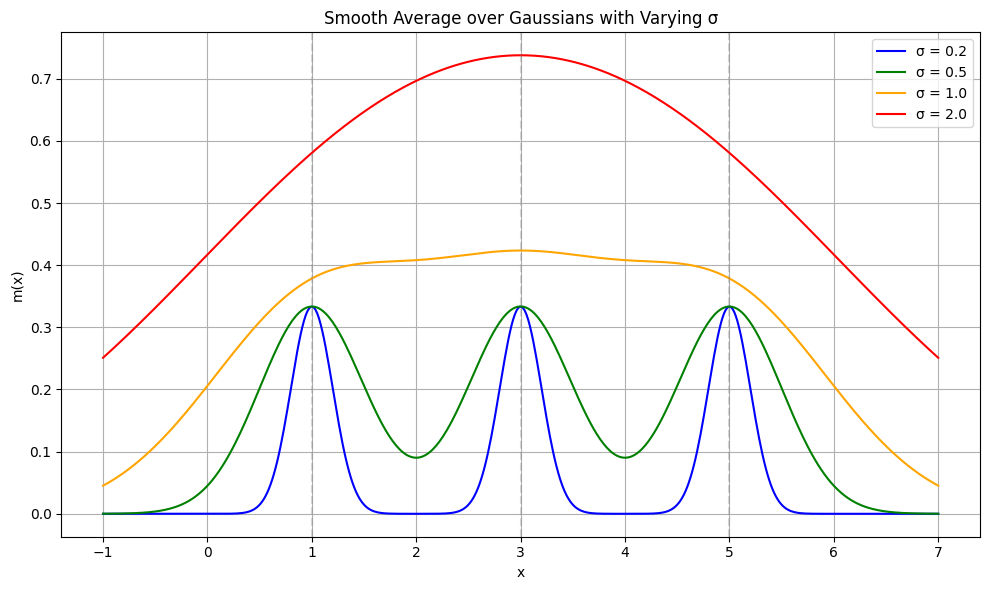

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define known prior compositions (mu_i) and weights (w_i)
mu = np.array([1.0, 3.0, 5.0])
weights = np.array([1.0, 1.0, 1.0])
weights = weights / weights.sum()  # Normalize

# Define the Gaussian kernel function
def rbf(x, mu_i, sigma):
    return np.exp(-((x - mu_i) ** 2) / (2 * sigma ** 2))

# Compute the weighted sum of Gaussians
def mean_function(x_vals, mu, weights, sigma):
    total = np.zeros_like(x_vals)
    for i in range(len(mu)):
        total += weights[i] * rbf(x_vals, mu[i], sigma)
    return total

# Generate x values
x_vals = np.linspace(-1, 7, 500)

# Plot for different sigma values
sigmas = [0.2, 0.5, 1.0, 2.0]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))
for sigma, color in zip(sigmas, colors):
    y_vals = mean_function(x_vals, mu, weights, sigma)
    plt.plot(x_vals, y_vals, label=f'σ = {sigma}', color=color)

# Plot centers
for m in mu:
    plt.axvline(m, color='gray', linestyle='--', alpha=0.3)

plt.title("Smooth Average over Gaussians with Varying σ")
plt.xlabel("x")
plt.ylabel("m(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

And a torch version identical to above.

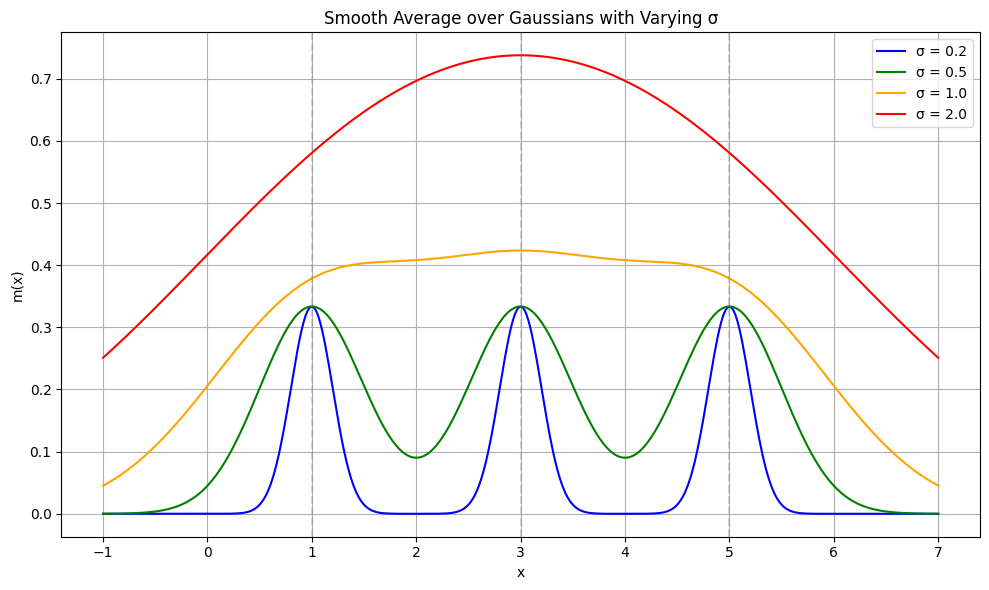

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Define known prior compositions (mu_i) and weights (w_i)
mu = torch.tensor([1.0, 3.0, 5.0])
weights = torch.tensor([1.0, 1.0, 1.0])  # uniform weights
weights = weights / weights.sum()       # normalize

# Define the Gaussian kernel function
def rbf(x, mu_i, sigma):
    return torch.exp(-((x - mu_i) ** 2) / (2 * sigma ** 2))

# Generate x values
x_vals = torch.linspace(-1, 7, 500)

# Compute the weighted sum of Gaussians
def mean_function(x_vals, mu, weights, sigma):
    total = torch.zeros_like(x_vals)
    for i in range(len(mu)):
        total += weights[i] * rbf(x_vals, mu[i], sigma)
    return total

# Plot for different sigma values
sigmas = [0.2, 0.5, 1.0, 2.0]
colors = ['blue', 'green', 'orange', 'red']

plt.figure(figsize=(10, 6))
for sigma, color in zip(sigmas, colors):
    y_vals = mean_function(x_vals, mu, weights, sigma)
    plt.plot(x_vals, y_vals, label=f'σ = {sigma}', color=color)

# Plot centers
for m in mu:
    plt.axvline(m.item(), color='gray', linestyle='--', alpha=0.3)

plt.title("Smooth Average over Gaussians with Varying σ")
plt.xlabel("x")
plt.ylabel("m(x)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()